In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os, cv2, torch, timm, optuna
import numpy as np, pandas as pd
import albumentations as A
from tqdm import tqdm
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [1]:
# DATA_DIR = '/kaggle/input/diabetic-retinopathy-224x224-2019-data/colored_images/'
# CSV_PATH = '/kaggle/input/diabetic-retinopathy-224x224-2019-data/train.csv'
# df = pd.read_csv(CSV_PATH)
# df['diagnosis'] = df['diagnosis'].astype(int)
# print(df.head())

In [4]:
DATA_DIR = '/kaggle/input/diabetic-retinopathy-224x224-2019-data/colored_images'
CSV_PATH = '/kaggle/input/diabetic-retinopathy-224x224-2019-data/train.csv'

df = pd.read_csv(CSV_PATH)
diagnosis_to_folder = {0: 'No_DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferate_DR'}
df['file_path'] = df.apply(lambda x: os.path.join(DATA_DIR, diagnosis_to_folder[x['diagnosis']], x['id_code'] + '.png'), axis=1)


In [6]:
class DRDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = cv2.imread(self.df.iloc[idx]['file_path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.df.iloc[idx]['diagnosis']
        if self.transforms: img = self.transforms(image=img)['image']
        return img, label


In [7]:
def get_transforms(phase):
    if phase == 'train':
        return A.Compose([
            A.RandomResizedCrop(size=(224, 224), scale=(0.85, 1.0)),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.Affine(scale=(0.9, 1.1), translate_percent=(0.05, 0.05), rotate=(-15, 15), p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(height=224, width=224),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])


In [9]:
class_counts = df['diagnosis'].value_counts().sort_index().values
weights = 1. / torch.tensor(class_counts, dtype=torch.float)
samples_weights = weights[df['diagnosis'].values]
sampler = WeightedRandomSampler(samples_weights, len(samples_weights), replacement=True)


In [10]:
def build_model(model_name, num_classes=5):
    model = timm.create_model(model_name, pretrained=True)

    if hasattr(model, 'fc'):
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif hasattr(model, 'classifier'):
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif hasattr(model, 'head'):
        if isinstance(model.head, nn.Linear):
            model.head = nn.Linear(model.head.in_features, num_classes)
        elif hasattr(model.head, 'fc') and isinstance(model.head.fc, nn.Linear):
            model.head.fc = nn.Linear(model.head.fc.in_features, num_classes)
        else:
            raise NotImplementedError(f"Unknown head structure for {model_name}")
    else:
        raise NotImplementedError(f"Unknown model structure for {model_name}")

    return model


In [12]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * ((1-pt) ** self.gamma) * ce_loss
        return focal_loss


In [14]:
def train_epoch(model, loader, optimizer, criterion, scaler, device):
    model.train()
    running_loss = 0
    for imgs, labels in tqdm(loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
    return running_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss, preds, targets = 0, [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(imgs)
                loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds.extend(outputs.argmax(1).cpu().numpy())
            targets.extend(labels.cpu().numpy())
    acc = (np.array(preds) == np.array(targets)).mean()
    return total_loss / len(loader), acc


In [17]:
def objective(trial):
    model_name = trial.suggest_categorical('model_name', ['tf_efficientnet_b0', 'resnet50', 'convnext_tiny'])
    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    wd = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)

    model = build_model(model_name).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    criterion = FocalLoss()
    scaler = torch.cuda.amp.GradScaler()

    train_loader = DataLoader(DRDataset(df, get_transforms('train')), batch_size=32, sampler=sampler)
    val_loader = DataLoader(DRDataset(df, get_transforms('valid')), batch_size=32, shuffle=False)

    best_acc = 0
    for _ in range(3):  # Fast tuning loop
        train_epoch(model, train_loader, optimizer, criterion, scaler, device)
        _, val_acc = validate(model, val_loader, criterion, device)
        best_acc = max(best_acc, val_acc)

    return best_acc


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print(study.best_params)


[I 2025-05-17 15:36:15,871] A new study created in memory with name: no-name-1b7ceb12-9aa3-42e4-afb7-55afcd031c58


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/tmp/ipykernel_35/712927634.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
  0%|          | 0/115 [00:00<?, ?it/s]/tmp/ipykernel_35/3901844418.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 115/115 [00:50<00:00,  2.28it/s]
/tmp/ipykernel_35/3901844418.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 115/115 [00:32<00:00,  3.49it/s]
[I 2025-05-17 15:39:21,302] Trial 0 finished with value: 0.5805570726379028 and parameters: {'model_name': 'resnet50', 'lr': 2.6626786278153794e-05, 'weight_decay': 1.9494820040315334e-06}. Best is trial 0 with value: 0.5805570726379028.


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

100%|██████████| 115/115 [00:27<00:00,  4.11it/s]
[I 2025-05-17 15:41:33,144] Trial 1 finished with value: 0.6384489350081922 and parameters: {'model_name': 'tf_efficientnet_b0', 'lr': 1.0947353582463337e-05, 'weight_decay': 0.00012532724807508118}. Best is trial 1 with value: 0.6384489350081922.


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

100%|██████████| 115/115 [02:00<00:00,  1.05s/it]
[I 2025-05-17 15:49:00,839] Trial 2 finished with value: 0.8129437465865648 and parameters: {'model_name': 'convnext_tiny', 'lr': 0.0001232572535086488, 'weight_decay': 1.431345958332436e-05}. Best is trial 2 with value: 0.8129437465865648.
100%|██████████| 115/115 [02:00<00:00,  1.05s/it]
[I 2025-05-17 15:56:25,221] Trial 3 finished with value: 0.8306936100491534 and parameters: {'model_name': 'convnext_tiny', 'lr': 8.774024562526195e-05, 'weight_decay': 2.9259341756548604e-05}. Best is trial 3 with value: 0.8306936100491534.
100%|██████████| 115/115 [00:30<00:00,  3.73it/s]
[I 2025-05-17 15:58:49,685] Trial 4 finished with value: 0.8418896777717094 and parameters: {'model_name': 'resnet50', 'lr': 0.0007248421758987482, 'weight_decay': 0.0001973561064880856}. Best is trial 4 with value: 0.8418896777717094.
100%|██████████| 115/115 [02:01<00:00,  1.05s/it]
[I 2025-05-17 16:06:14,869] Trial 5 finished with value: 0.8058438012015292 and p

{'model_name': 'tf_efficientnet_b0', 'lr': 0.000521289028465146, 'weight_decay': 0.000543299172456562}


In [1]:
#Best {'model_name': 'tf_efficientnet_b0', 'lr': 0.000521289028465146, 'weight_decay': 0.000543299172456562}

In [24]:
params = study.best_params
model = build_model(params['model_name']).to(device)
optimizer = optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
criterion = FocalLoss()
scaler = torch.cuda.amp.GradScaler()

train_loader = DataLoader(DRDataset(df, get_transforms('train')), batch_size=32, sampler=sampler)
val_loader = DataLoader(DRDataset(df, get_transforms('valid')), batch_size=32, shuffle=False)

for epoch in range(10):
    print(f"Epoch {epoch+1}")
    train_loss = train_epoch(model, train_loader, optimizer, criterion, scaler, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

torch.save(model.state_dict(), 'best_dr_model.pth')
print("Model saved!")


/tmp/ipykernel_35/2780012178.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1


  0%|          | 0/115 [00:00<?, ?it/s]/tmp/ipykernel_35/3901844418.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 115/115 [00:28<00:00,  4.10it/s]
/tmp/ipykernel_35/3901844418.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.4426 | Val Loss: 0.1232 | Val Acc: 0.7755
Epoch 2


100%|██████████| 115/115 [00:28<00:00,  4.06it/s]


Train Loss: 0.1867 | Val Loss: 0.0656 | Val Acc: 0.8367
Epoch 3


100%|██████████| 115/115 [00:29<00:00,  3.95it/s]


Train Loss: 0.1184 | Val Loss: 0.0369 | Val Acc: 0.8706
Epoch 4


100%|██████████| 115/115 [00:28<00:00,  4.04it/s]


Train Loss: 0.0905 | Val Loss: 0.0234 | Val Acc: 0.8984
Epoch 5


100%|██████████| 115/115 [00:28<00:00,  4.04it/s]


Train Loss: 0.0596 | Val Loss: 0.0170 | Val Acc: 0.9164
Epoch 6


100%|██████████| 115/115 [00:28<00:00,  4.04it/s]


Train Loss: 0.0434 | Val Loss: 0.0164 | Val Acc: 0.9233
Epoch 7


100%|██████████| 115/115 [00:28<00:00,  3.97it/s]


Train Loss: 0.0280 | Val Loss: 0.0142 | Val Acc: 0.9148
Epoch 8


100%|██████████| 115/115 [00:28<00:00,  4.02it/s]


Train Loss: 0.0242 | Val Loss: 0.0077 | Val Acc: 0.9410
Epoch 9


100%|██████████| 115/115 [00:28<00:00,  4.05it/s]


Train Loss: 0.0234 | Val Loss: 0.0050 | Val Acc: 0.9528
Epoch 10


100%|██████████| 115/115 [00:28<00:00,  4.06it/s]


Train Loss: 0.0169 | Val Loss: 0.0041 | Val Acc: 0.9517
Model saved!


/tmp/ipykernel_35/1114841134.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


                precision    recall  f1-score   support

         No_DR       1.00      0.98      0.99      1805
          Mild       0.84      0.95      0.89       370
      Moderate       0.97      0.89      0.93       999
        Severe       0.81      0.96      0.88       193
Proliferate_DR       0.88      0.97      0.92       295

      accuracy                           0.95      3662
     macro avg       0.90      0.95      0.92      3662
  weighted avg       0.96      0.95      0.95      3662



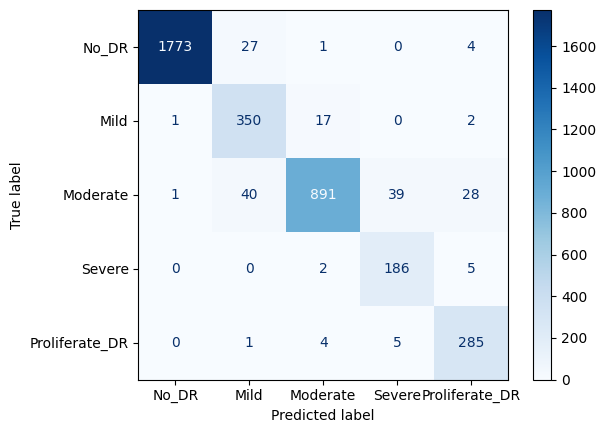

In [25]:
model.eval()
preds, targets = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        with torch.cuda.amp.autocast():
            outputs = model(imgs)
        preds.extend(outputs.argmax(1).cpu().numpy())
        targets.extend(labels.numpy())

print(classification_report(targets, preds, target_names=diagnosis_to_folder.values()))

cm = confusion_matrix(targets, preds)
ConfusionMatrixDisplay(cm, display_labels=diagnosis_to_folder.values()).plot(cmap='Blues')
plt.show()


In [26]:
import os
from IPython.display import FileLink

# Check current directory contents
print("Contents of /kaggle/working:")
print(os.listdir('/kaggle/working'))

# If file exists, show download link
if 'best_dr_model.pth' in os.listdir('/kaggle/working'):
    print("\n✅ File found! Click link to download:")
    display(FileLink('/kaggle/working/best_dr_model.pth'))
else:
    print("\n❌ File not found in /kaggle/working. Check file path or saving code.")


Contents of /kaggle/working:
['.virtual_documents', 'best_dr_model.pth']

✅ File found! Click link to download:


/kaggle/working/best_dr_model.pth